# Google Earth Engine with Python: `EasyEarth` class

## 2020년 08월 30일 안상호

`EasyEarth` 클래스를 사용하여 Google Earth Engine의 기초적인 사용법과 응용 방법에 대해서 알아보도록 하겠습니다. 

1. Quick Start 
2. EasyEart Start
3. EasyEart Usage



# Requirement

## Import Package

In [9]:
# Installs geemap package
import subprocess
import math

import requests
from PIL import Image
from io import BytesIO

try:
  ee.initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize()


try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as geemap
except:
    import geemap

# Authenticates and initializes Earth Engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()  

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=1XalxDUEEu5X_zn4nw4k4pYo_o5YgDAf-ceiLIVq-4Q&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/3gEHYSVya_hRE6TBDR9qYDvwqcw1wZ1wFwGKAuYn6lSmjLZK3yx8czE

Successfully saved authorization token.


colab은 google earth engine이 설치되어 있으므로 바로 적용해볼 수 있다는 장점이 있습니다.

하지만 클라우드 플랫폼에서 서비스 인증을 받아야 하는데, 
**반드시** 본 실습에 앞서서 Google Earth Engine의 인증 절차를 거치시기 바랍니다..

- [서비스 연동 key 생성 방법](https://developers.google.com/earth-engine/service_account)
- [Earth Engine 신청](https://docs.google.com/forms/d/e/1FAIpQLScFk_pkrrDDF4O8imsEBMaryLDU-Ghf44eHbgujIAl_SXJTJQ/viewform)
- [colab 세팅](https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb)






```
IAM 및 관리자 > 서비스 계정 > 서비스 계정 만들기

1. 이름
2. 역할 > 프로젝트 편집자
```

In [10]:
class EasyEarth:

  def __init__(self, dataset):
    self.dataset = ee.ImageCollection(dataset)

  def change_dataset(self, dataset):
    self.dataset = ee.ImageCollection(dataset)

  
  def select_AOI(self, lat, lon, k = 10, dates=None, cloud_name = "CLOUD_COVER" ,cloud_pct=None):
    self.outer_AOI = self.__create_AOI(lat, lon, k / 50)
    self.AOI = self.__create_AOI(lat, lon, k)
    self.data_AOI = self.dataset.filterBounds(self.AOI)
    if dates is not None:
      self.data_AOI = self.__filter_dates(self.data_AOI, dates)
    if cloud_pct is not None:
      self.data_AOI = self.__filter_cloudy(by=cloud_name, cloud_pct=cloud_pct)

    self.AOI_size = self.data_AOI.size().getInfo()

        

  def __create_AOI(self, lat, lon, s=10):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    geometry = ee.Geometry.Polygon([[[lon - v, lat + v],
                                     [lon - v, lat - v],
                                     [lon + v, lat - v],
                                     [lon + v, lat + v]]], None, False)

    return geometry #ee.Geometry.Rectangle([lon - v, lat - v, lon + v, lat + v])

  def __filter_dates(self, col, dates):
    return col.filterDate(dates[0], dates[1])


  def __filter_cloudy(self, by="CLOUDY_PIXEL_PERCENTAGE", cloud_pct=5):
    """
    주로 Sentinel(COPERNIQUS)에서 구름 양을 조절하기 위해 사용합니다.
    """
    return self.data_AOI.filter(ee.Filter.lte(by, cloud_pct))



  
  def sort_by(self, method = 'CLOUD_COVER', ascending=True):
    sorted_collections = self.data_AOI.sort(method, ascending)
    self.data_AOI = sorted_collections


  def plot_image(self, img, paramters, cloud_name = 'CLOUD_COVER'):
    
    cloud_pct = img.get(cloud_name).getInfo()
    # print(f'Cloud Cover (%): {cloud_pct}')

    url = img.getThumbUrl(parameters)
    response = requests.get(url)
    
    return cloud_pct, Image.open(BytesIO(response.content))


  def get_collections_at(self, idx, collections=None):
    if collections is not None:
      size = collections.size().getInfo()
      return ee.Image(collections.toList(size).get(idx))
    else:
      return ee.Image(self.data_AOI.toList(self.AOI_size).get(idx))

  def save_image(self, save_path, image):
    plt.imsave(save_path, np.array(image))
    # print(str(save_path) + " complete")

  def calculate_alpha_ratio(self, image):
    img_array = np.array(image)
    return np.sum(img_array == 0) / img_array.size
    
  def get_ndvi(self,image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    region = self.geometry
    # Use a mean reducer.
    reducer = ee.Reducer.mean()

    # Compute the unweighted mean.
    ndvi_value = ndvi.select(['NDVI']).reduceRegion(reducer, region, 10)
    return ndvi_value.getInfo()['NDVI']
  def get_ndbi(self,image):
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    region = self.geometry
    # Use a mean reducer.
    reducer = ee.Reducer.mean()

    # Compute the unweighted mean.
    ndbi_value = ndbi.select(['NDBI']).reduceRegion(reducer, region, 10)
    return ndbi_value.getInfo()['NDBI']
  
  def get_ui(self,image):
     Ndvi = image.normalizedDifference(['B8', 'B4'])
     Ndbi = image.normalizedDifference(['B11', 'B8'])
     Ui = Ndbi.subtract(Ndvi).rename('Ui');
     region = self.geometry
     reducer = ee.Reducer.mean()
     Ui_value = Ui.select(['Ui']).reduceRegion(reducer, region, 10)
     return Ui_value.getInfo()['Ui']

# 1. Quick Start

Google Earth Engine API를 실습해 봄으로써, 작동 원리에 대해서 알아보도록 하겠습니다.

다음의 Quick Start는 Medium의 [A Quick Introduction to Google Earth Engine](https://towardsdatascience.com/a-quick-introduction-to-google-earth-engine-c6a608c5febe)를 참고하여 작성되었습니다. 

우선 Quick Start를 시작하기 전에 처음 진행해야하는 몇가지 절차들이 있습니다.

1. Apply for Earth Engine
2. Create a Google Cloud project
3. Enable the Earth Engine API on the project
4. Create a service account and download a key file for the service account

앞의 Package Import 부분에서도 이미 진행하셨겠지만, Google Earth Engine을 사용하기 위해서는 우선 API 인증을 받아야 합니다. 

다음과 같은 두줄의 코드로 인증을 진행하거나, 따로 인증 [Credential](https://developers.google.com/earth-engine/guides/service_account)을 만들어서 읽어오는 방법이 있습니다.


## 1.1. API 인증

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=hrWEhqwGzTKnrTX0pbUE_XC1s6hNgzJU3W2jl30CTwQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/3gGvzk-qvVUD50kqmvOVjFinVbIFZhfGh3ISMs3NYVU2wuKFu0zy3t4

Successfully saved authorization token.


## 1.2. 데이터셋 선택 및 필터링

Google Earth는 다양한 인공위성 데이터를 무료로 제공하고 있는데, [데이터 카탈로그](https://developers.google.com/earth-engine/datasets/)에서 어떤 데이터를 사용할 수 있는지 확인할 수 있습니다. 

각 데이터셋이 사용 목적에 따라 묶여 있는데, 들어가보면 어느 시점의 데이터를 얻을 수 있는지 그리고 상세한 설명서에 대해서 확인할 수 있습니다. 

Quick Start에서는  위성 Sentinel-2의 [MultiSpectral Instrument, Level-1C](Sentinel-2)를 사용해보도록 하겠습니다.



In [26]:
landsat = ee.ImageCollection("COPERNICUS/S2")

`ImageCollection`으로 얻어진 데이터는 모든 기간, 모든 장소가 포함된 데이터로 조사하고자 하는 관심 지역(AOI: Area of Interest)을 선택해야 합니다.

그래서 대부분 사각형의 형태로 네 개의 Point를 지정하게 되는데 위도와 경도를 중심으로 $m \ \text{km} \times m \ \text{km}$ 의 범위를 설정해주는 절차를 진행하고, 시간 또한 필터링 할 수 있습니다.     

다음의 반경 공식 및 코드는 Jean, Neal, et al.(2016)의 논문 내용을 Pytorch 기반으로 구현한 [Github](https://github.com/jmather625/predicting-poverty-replication/blob/master/utils/utils.py)에서 발췌하였습니다. 


In [27]:
lat = 37.647125
lon = 128.685141

m = 5
# Creates a s km x s km square centered on (lat, lon)
v = (180/math.pi)*(500/6378137)*m 
geometry = ee.Geometry.Polygon([[[lon - v, lat + v],
                                 [lon - v, lat - v],
                                 [lon + v, lat - v],
                                 [lon + v, lat + v]]], None, False)

landsat_AOI = landsat.filterBounds(geometry).filterDate('2019-07-01','2019-12-01')

## 1.3. 위성 사진 시각화

Landsat을 비롯한 대부분의 위성 이미지 데이터들은 구름양의 산출을 기본 알고리즘으로 탑재하고 있습니다.

따라서 가장 흐리지 않고 선명한 사진을 얻을 수 있습니다.

In [28]:
# 현재 Collection이 포함하고 있는 데이터의 수
size = landsat_AOI.size().getInfo()
size

61

In [32]:
# the 2th least cloudy image
landsat_AOI = landsat_AOI.sort('CLOUDY_PIXEL_PERCENTAGE')
least_cloudy = ee.Image(landsat_AOI.toList(size).get(2))

# how cloudy is it?
print('Cloud Cover (%):', least_cloudy.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

Cloud Cover (%): 0.235


시각화를 위해서 미세한 매개변수들을 조정할 수 있는데, 대표적으로 다음과 같은 parameter를 사용할 수 있습니다.

- `dimensions`: 이미지를 몇 픽셀의 이미지로 요청할 것인지에 대한 정보입니다.
- `bands`: 인공위성의 여러 밴드중 어떤 밴드를 가져올 것인지로, [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2#bands)에서는 **B4**(Red), **B3**(Green), **B2**(Blue)를 나타내며 인공위성마다 밴드 명칭이 상이할 수 있습니다.
- `region`: 어느 부분을 보여줄지 정하는 것으로 예제에서는 앞서 설정한 `geometry`를 사용하도록합니다.

In [33]:
parameters = {'min': 0,
              'max': 2000,
              'dimensions': 1024,
              'bands': ['B4', 'B3', 'B2'],
              'region': geometry}

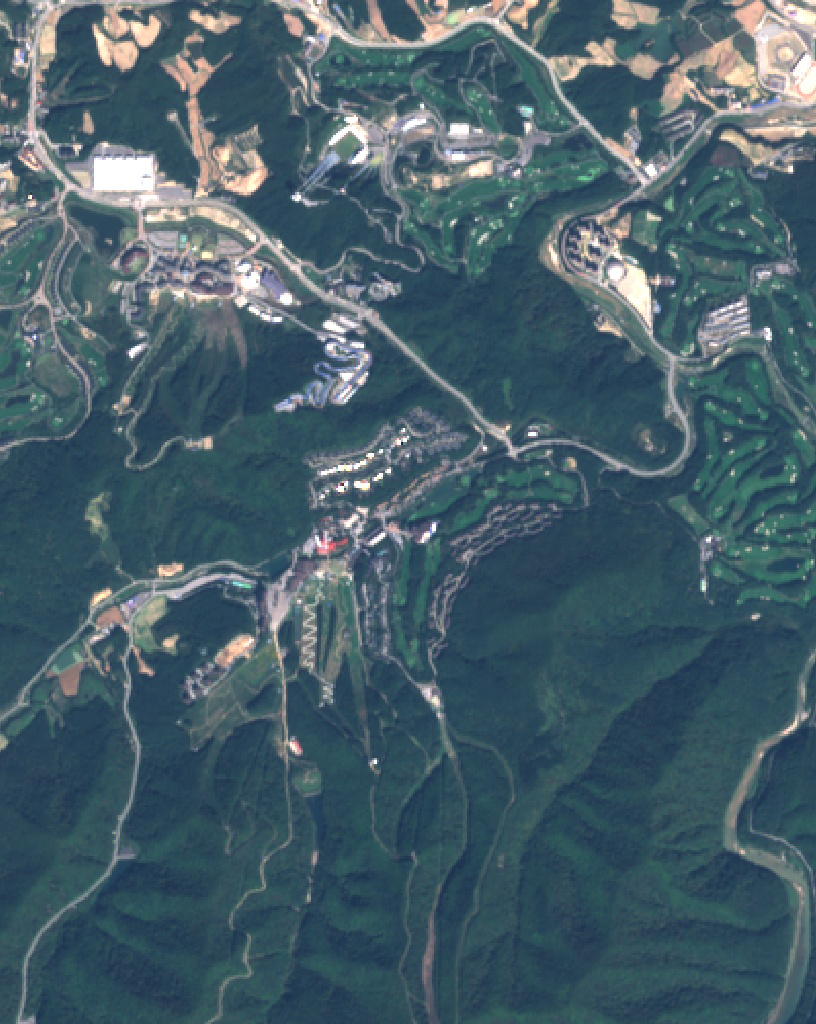

In [34]:
url = least_cloudy.getThumbUrl(parameters)
response = requests.get(url)

Image.open(BytesIO(response.content))

# 2. EasyEarth Start 

이제 EasyEarth 클래스를 이용하여 위의 과정을 보다 쉽고 간단하게 할 수 있는 방법에 대해서 알아보도록 하겠습니다.

또한 이미지를 저장하는 방법에 대해서도 설명드리겠습니다.

## 2.1. 데이터셋 선정

In [41]:
#위성 이미지 불러오기
earth = EasyEarth('COPERNICUS/S2')
lat = 37.647125
lon = 128.685141

##위도,경도,반경 몇키로, 날짜, image_sort기준, 구름 몇 %이하로 설정할 것인지
earth.select_AOI(lat,lon, 5, ("2020-04-01", "2020-04-30"), "CLOUDY_PIXEL_PERCENTAGE", 10)

parameters = {
  'min': 0.0,
  'max': 2500,
  'bands': ['B4', 'B3', 'B2'],
  'dimensions': 512,
  'region': earth.AOI
}
earth.sort_by("CLOUDY_PIXEL_PERCENTAGE")

image = earth.get_collections_at(0)

## 2.2. 이미지 시각화

구름 비율:0.0794


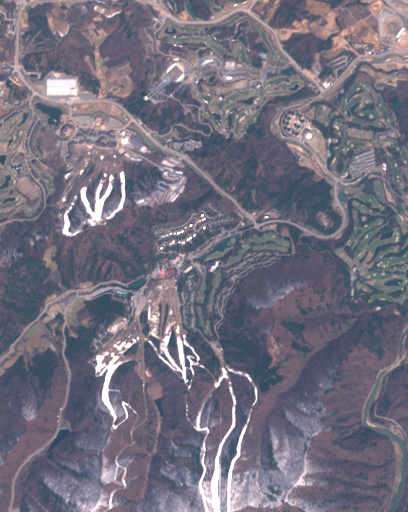

In [42]:
cloud_pct, img = earth.plot_image(image.resample('bicubic'), parameters, "CLOUDY_PIXEL_PERCENTAGE")

print(f"구름 비율:{cloud_pct}")
img

## 2.3. 이미지 저장

In [ ]:
earth.save_image("/path/to/save/file.jpg", img)

# 3. EasyEarth Usage



## 3.1. NDVI 산출

## 3.2. Machine Learning

# Reference

## 공식

- 공식 [사이트](https://developers.google.com/earth-engine): Google Earth Engine에 대한 가장 자세한 설명을 다루고 있는데, 주로 javascript에 대한 예제를 다룬다는 아쉬움이 있습니다.
- 공식 [Github](https://github.com/google/earthengine-api): python의 example로 가시면 다양한 예제를 다루는 것을 확인할 수 있습니다.
- Google Earth Engine Case Study [[Link]](https://earthengine.google.com/case_studies/)
- Google Earth Engine Dataset [[Link]](https://developers.google.com/earth-engine/datasets/)


## 논문

- Jean, Neal, et al. **"Combining satellite imagery and machine learning to predict poverty."** *Science* 353.6301 (2016): 790-794.
